## Libraries

In [1]:
# %load_ext autoreload
# %autoreload 2

import sys
sys.path.append('..')
from src.grass_functions import*

# Parameters

In [ ]:
#set project variables
Project_Area = 'test2024'
GRASS_GIS_Projection = projection = '5070' #set to None if you want to use the DEM's original projection
res = '1m'

## Set variables analysis
data_scale = 'HUC12' #other options HUC12, HUC10, HUC8 OR the field name of the source data to be split <-- case sensitive
select_data = '020600060201' #     # Value within the filter_field used for data selection
to_headwaters = False #False if only interested in local huc area
input_shp_name = None #None or must be populated populated with a shapefile polygons if data_scale != HUCXX
buffer = 2000
auto_delete = False
aligned = False
dem =  f'dem' #f'dem_{select_data}'

In [2]:
#set project variables
Project_Area = 'test2024'
GRASS_GIS_Projection = projection = '5070' #set to None if you want to use the DEM's original projection
res = '1m'

## Set variables analysis
data_scale = 'HUC12' #other options HUC12, HUC10, HUC8 OR the field name of the source data to be split <-- case sensitive
select_data = '020600060201' #     # Value within the filter_field used for data selection
to_headwaters = False #False if only interested in local huc area
input_shp_name = None #None or must be populated populated with a shapefile polygons if data_scale != HUCXX
buffer = 2000
auto_delete = False
aligned = False
dem =  f'dem' #f'dem_{select_data}'
carved = True
threshold = 25899 #cells

### Start new grass session

In [7]:
#set projection if none exists
if not GRASS_GIS_Projection:
    dem_vrt = raster_dir/'dem'/'dem_{}.vrt'.format(select_data)
    GRASS_GIS_Projection = projection = get_raster_epsg(dem_vrt)
## GRASSGIS Location and Mapsets
Location = Project_Area+'_'+GRASS_GIS_Projection
Mapset = 'PERMANENT'

In [8]:
initialize_grass_db(Location, Mapset, GRASS_GIS_Projection)

Database Location Exists
Database Mapset Exists
None
{'GISDBASE': '/home/grassdata', 'LOCATION_NAME': 'nebraska_regression_stantec_26852', 'MAPSET': 'PERMANENT'}


Current GRASS GIS 7 environment:


#### Review existing files

In [9]:
#list all grass files
grass_maps = list_existing_grass()

Available vector maps:
aoi@PERMANENT
aoi_buffer@PERMANENT
nhd1027@PERMANENT
outlets_10270204@PERMANENT
outlets_10270204_moved@PERMANENT
stream_10270204@PERMANENT
stream_import@PERMANENT
tmp_bsn@PERMANENT
tmp_bsn_buffer@PERMANENT
v_basins_10270204@PERMANENT
vreg_511@PERMANENT

Available raster maps:
MASK@PERMANENT
accum_10270204@PERMANENT
dem_10270204@PERMANENT
dem_10270204_a@PERMANENT
dem_10270204_a_b@PERMANENT
drain_dir_10270204@PERMANENT
r_basins_10270204@PERMANENT
r_streams_10270204@PERMANENT
state_dem@PERMANENT
state_dem_b@PERMANENT
subbasins_10270204@PERMANENT


In [10]:
#remove old files if needed
remove_grass_data(grass_maps,'None','vector') #all as 

In [11]:
basin_list = aoi[data_scale.lower()].to_list()
basins = 'aoi'
gs.run_command('v.import', input= huc_path,  output= basins)
print('added aoi to grass')

Check if OGR layer <nebraska_regression_stantec_10270204_aoi> contains
polygons...
   0 100
Creating attribute table for layer
<nebraska_regression_stantec_10270204_aoi>...
Importing 1 features (OGR layer
<nebraska_regression_stantec_10270204_aoi>)...
   0 100
-----------------------------------------------------
Registering primitives...
-----------------------------------------------------
Cleaning polygons
-----------------------------------------------------
Breaking polygons...
Breaking polygons (pass 1: select break points)...
 100
Breaking polygons (pass 2: break at selected points)...
 100
-----------------------------------------------------
Removing duplicates...
 100
-----------------------------------------------------
Breaking boundaries...
   0 100
-----------------------------------------------------
Removing duplicates...
 100
-----------------------------------------------------
Cleaning boundaries at nodes...
 100
-----------------------------------------------------


added aoi to grass


Input
</home/data/Vectors/nebraska_regression_stantec/nebraska_regression_stantec_10270204_aoi.geojson>
successfully imported without reprojection


In [6]:
if aligned:
    dem +='_a'
if carved:
    dem +='_b'
accum = f'accum_{select_data}'
drain_dir = f'drain_dir_{select_data}'
r_basins = f'r_basins_{select_data}'
v_basins = f'v_basins_{select_data}'
sub_basins = f'subbasins_{select_data}'
v_stream = f'stream_{select_data}'
r_streams = f'r_streams_{select_data}'

## Paths:
parent_dir = pl.Path(os.getcwd()).parent/'data'
current_dir = pl.Path(os.getcwd())
outputs_dir =parent_dir/'Rasters'/Project_Area/'Outputs'
vector_dir = parent_dir/'Vectors'/Project_Area
raster_dir = parent_dir/'Rasters'/Project_Area
huc_path = vector_dir/'{}_aoi.geojson'.format(Project_Area)
git_data_repo = current_dir/'data_repository'
if input_shp_name:
    input_shp = git_data_repo/input_shp_name
directory = outputs_dir

if data_scale.find('HUC') >= 0:
    huc_level = re.findall("[0-9]+",data_scale)[0]
    if huc_level == str(len(select_data)):
        huc_digys = huc_level
    else:
        huc_digys = huc_level
        select_data = select_data[:int(huc_digys)]

#read from to vector path from notebook 1
huc_path = vector_dir/'{0}_{1}_aoi.geojson'.format(Project_Area,select_data)
aoi = gpd.read_file(str(huc_path),driver="GeoJSON")

In [12]:
assert dem+"@PERMANENT" in grass_maps['raster'], 'Check that dem exists in GRASS'

In [13]:
#add mask and reset region
gs.run_command('v.buffer',input=basins,output=basins+'_buffer',distance = buffer)
#mask outside cells
gs.run_command('r.mask',vector = basins+'_buffer')

Buffering areas...
 100
Cleaning buffers...
Building parts of topology...
Building topology for vector map <aoi_buffer@PERMANENT>...
Registering primitives...
Snapping boundaries...
Reading features...
Snap vertices Pass 1: select points
   0  50 100
Snap vertices Pass 2: assign anchor vertices
   4   9  14  19  24  29  34  39  44  49  54  59  64  69  74  79  84  89  94  99 100
Snap vertices Pass 3: snap to assigned points
   0  50 100
Breaking polygons...
Breaking polygons (pass 1: select break points)...
  50 100
Breaking polygons (pass 2: break at selected points)...
  50 100
Removing duplicates...
  50 100
Breaking boundaries...
   0  50 100
Removing duplicates...
  50 100
Cleaning boundaries at nodes
  50 100
Building topology for vector map <aoi_buffer@PERMANENT>...
Building areas...
   0  50 100
Removing dangles...
  50 100
Removing bridges...
  50 100
Attaching islands...
Building topology for vector map <aoi_buffer@PERMANENT>...
Attaching islands...
   0  50 100
Calculating ce

0

In [14]:
#set the region based on the buffer but align with DEM raster
gs.run_command('g.region',raster = dem,align=dem,zoom=dem)

0

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
d.vect complete.


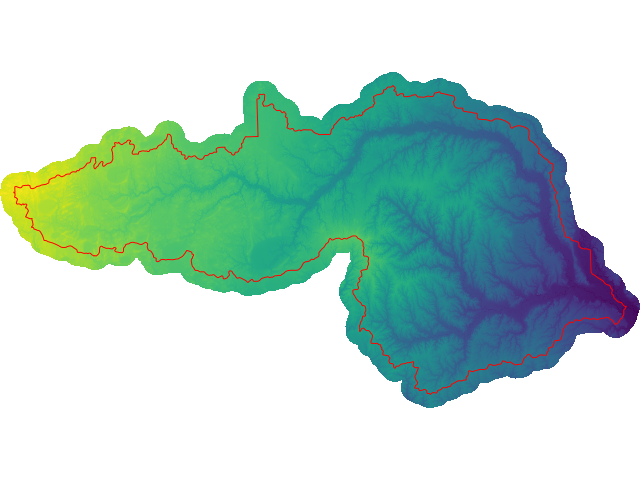

In [15]:
gs.run_command('d.erase')
gs.run_command('d.rast', map= dem)
gs.run_command('d.vect', map= 'aoi',color='red',fill_color='None')
Image(filename="map.png")

In [16]:
if outlet_aois:
    outlets = f'outlets_{select_data}'
    gs.run_command('v.import', input=  vector_dir/outlet_shp,  output= outlets)

Check if OGR layer <Turkey_Gages> contains polygons...
   0  50 100
         overwritten
Creating attribute table for layer <Turkey_Gages>...
Importing 2 features (OGR layer <Turkey_Gages>)...
   0  50 100
-----------------------------------------------------
Building topology for vector map <outlets_10270204@PERMANENT>...
Registering primitives...
Input </home/data/Vectors/nebraska_regression_stantec/Turkey_Gages.shp>
successfully imported without reprojection


## Calculate Watershed Attributes and basin Delineation at Points

In [17]:
reg = gs.parse_command('g.region', raster=dem, flags='pg', zoom=dem,align=dem)
cell_size = float(reg.nsres)

In [19]:
gs.run_command('r.watershed', elevation=dem,threshold = threshold,accumulation=accum,drainage=drain_dir,basin=sub_basins,stream=r_streams,flags='sab')

SECTION 1a (of 5): Initiating Memory.
SECTION 1b (of 5): Determining Offmap Flow.
   0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  84  88  92  96 100
SECTION 2: A* Search.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
SECTION 3: Accumulating Surface Flow with SFD.
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100
SECTION 4: Watershed determination.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
SECTION 5: Closing Maps.
  68 100
Writing out only positive flow accumulation values.
Cells w

0

In [21]:
print("Converting the delineated watershed rasters to vectors")
gs.run_command('r.to.vect', input=r_basins, output= v_basins, type="area", flags='s')

print("Get basin ID from the raster")
basin_IDs = gs.parse_command('r.describe',map = r_basins, flags = '1n' )
basin_list = [int(x) for x in [*basin_IDs]]

Converting the delineated watershed rasters to vectors


         overwritten
Extracting areas...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Writing areas...
   0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  84  88  92  96 100
Building topology for vector map <v_basins_10270204@PERMANENT>...
Registering primitives...
Building areas...
   0   4   9  14  19  23  28  33  38  42  47  52  57  61  66  71  76  80  85  90  95 100
Attaching islands...
   0 100
Attaching centroids...
   0  25  50  75 100
r.to.vect complete.


Get basin ID from the raster


   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


In [22]:
gs.run_command('v.out.ogr',input=v_basins , output=vector_dir/f'basins_{select_data}.shp', format ='ESRI_Shapefile')

Exporting 11 areas (may take some time)...
   9  18  27  36  45  54  63  72  81  90 100
         category are written only when -c flag is given.
v.out.ogr complete. 4 features (Polygon type) written to
<v_basins_10270204> (ESRI_Shapefile format).


0

## Plot the Results

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
d.vect complete.
d.vect complete.


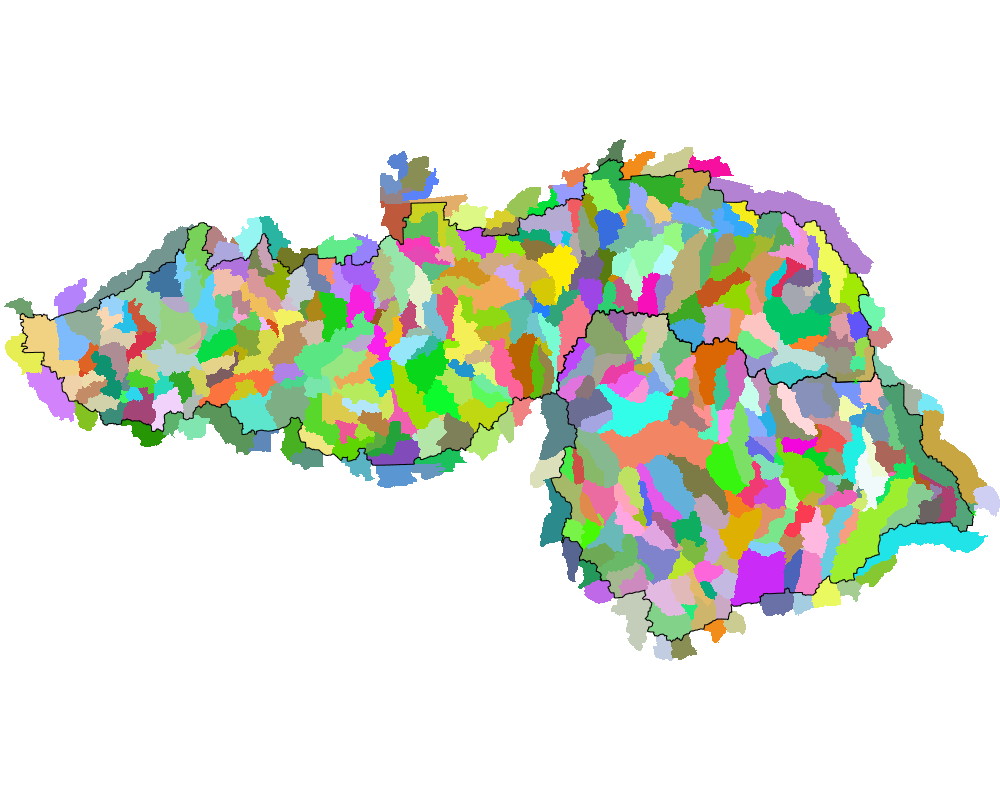

In [23]:
os.environ['GRASS_RENDER_WIDTH'] ='1000' #the width of the image map (default is 640).
os.environ['GRASS_RENDER_HEIGHT']='800' #the height of the image map (default is 480).
gs.run_command('d.erase')
gs.run_command('d.rast', map=sub_basins)
gs.run_command('d.rast', map=r_streams)
if outlet_aois:
    gs.run_command('d.vect', map=v_basins,color='black',fill_color='none')
    gs.run_command('d.vect', map=f'{outlets}_moved',color='green',fill_color='none')
#gs.run_command('d.vect', map=v_stream,color='blue',fill_color='none')
Image(filename="map.png")

In [24]:
# exports

In [25]:
out_rasts = [accum, drain_dir, sub_basins]
for rast in out_rasts:
    gs.run_command('r.out.gdal', input= rast, output= raster_dir/f'{rast}.tif',createopt="BIGTIFF=YES,PROFILE=GeoTIFF,TFW=YES,COMPRESS=LZW",flags='f')

Checking GDAL data type and nodata value...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Using GDAL data type <Float64>
Input raster map contains cells with NULL-value (no-data). The value -nan
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...
ERROR 6: SetColorTable() only supported for Byte or UInt16 bands in TIFF format.
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
r.out.gdal complete. File
</home/data/Rasters/nebraska_regression_stantec/accum_10270204.tif>
created.
Checking GDAL data type and nodata value...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Using GDAL data type <Int16>
Input raster map contains ce

# END